### Density Estimation of Income Risks

- Following Manski et al.(2009)
- Three cases 
   - case 1. 3+ intervales with positive probabilities, to be fitted with a generalized beta distribution
   - case 2. exactly 2 adjacent intervals with positive probabilities, to be fitted with a triangle distribution 
   - case 3. one interval only, to be fitted with a uniform distribution

In [1]:
from scipy.stats import gamma
from scipy.stats import beta 
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np
import pandas as pd

### Case 1. Generalized Beta Distribution

In [2]:
def GeneralizedBetaEst(bin,probs):
    """
    This fits a histogram with positive probabilities in at least 3 bins to a generalized beta distribution.
    Depending on if there is open-ended bin on either side with positive probability, 
       the estimator decides to estimate 2 or 4 parameters, respectively. 
       
    paramters
    ---------
    bin:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
                 
    returns
    -------
    moments:  ndarray of 2 or 4  
              2:  alpha and beta 
              4:  alpha, beta, lb, ub, e.g. lb=0 and ub=1 for a standard beta distribution
    """
    # n+1 bins and n probs, both are arrays
    if sum([probs[i]>0 for i in range(len(bin)-1)])<3:
        print("Warning: at least three bins with positive probs are needed")
        para_est=[]
    if sum(probs)!=1:
        print("probs need to sum up to 1")
        para_est=[]
    else:
        cdf = np.cumsum(probs)
        pprob=[i for i in range(len(bin)-1) if probs[i]>0]
        lb=bin[min(pprob)]
        print("lower bound is "+str(lb))
        ub=bin[max(pprob)+1]
        print("upper bound is "+str(ub))
        x0_2para = (2,1)
        x0_4para = (2,1,0,1) 
        def distance2para(paras2): # if there is no open-ended bin with positive probs 
            a,b=paras2
            distance= sum((beta.cdf(bin[1:],a,b,loc=lb,scale=ub-lb)-cdf)**2)
            return distance
        def distance4para(paras4): # if either on the left or right side one open-ended bin is with postive probs
            a,b,lb,ub=paras4
            distance= sum((beta.cdf(bin[1:],a,b,loc=lb,scale=ub-lb)-cdf)**2)
            return distance
        if lb==bin[0] and ub==bin[-1]:
            para_est = minimize(distance4para,x0_4para,method='CG')['x']
        else:
            para_est = minimize(distance2para,x0_2para,method='CG')['x']
        return para_est   # could be 2 or 4 parameters 

In [3]:
def GeneralizedBetaStats(alpha,beta,lb,ub):
    """
    This function computes the moments of a generalized beta distribution, mean and variance for now. 
    
    parameters
    ----------
    alpha, beta, lb, ub: floats 
    
    returns
    -------
    dict:  2 keys
           mean, float 
           variance, float 
    """
    # lb=0 and ub=1 for a standard beta distribution
    mean = lb + (ub-lb)*alpha/(alpha+beta)
    var = (ub-lb)**2*alpha*beta/((alpha+beta)**2*(alpha+beta+1))
    return {"mean": mean,"variance":var}

### Case 2. Isosceles Triangle distribution

Two adjacent intervales $[a,b]$,$[b,c]$ are assigned probs $\alpha$ and $1-\alpha$, respectively. In the case of $\alpha<1/2$, we need to solve parameter $t$ such that $[b-t,c]$ is the interval of the distribution. Denote the height of the trangle distribution $h$. Then following two restrictions need to satisfy

\begin{eqnarray}
\frac{t^2}{t+c-b} h = \alpha \\
(t+(c-b))h = 2
\end{eqnarray}

The two equations can solve $t$ and $h$

$$\frac{t^2}{(t+c-b)^2}=\alpha$$

$$t^2 = \alpha t^2 + 2\alpha t(c-b) + \alpha(c-b)^2$$

$$(1-\alpha) t^2 - 2\alpha(c-b) t - \alpha(c-b)^2=0$$

$$\implies t =\frac{2\alpha(c-b)+\sqrt{4\alpha^2(c-b)^2+4(1-\alpha)\alpha(c-b)^2}}{2(1-\alpha)} = \frac{\alpha(c-b)+(c-b)\sqrt{\alpha}}{(1-\alpha)}$$

$$\implies h = \frac{2}{t+c-b}$$


In [4]:
def TriangleEst(bin,probs):
    """
    The function fits histograms with exactly two adjacent 
       bins with positive probabilitie to a triangular distribution.
    It genetes the bounds of the isoceles triangle distribution. 
    
    paramters
    ---------
    bin:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
    
    returns
    --------
    dict: 3 keys
          lb: float, left bound 
          ub: float, right bound
          h:  float, height of the triangle
    
    """
    if sum([probs[i]>0 for i in range(len(bin)-1)])==2:
        print("There are two bins with positive probs")
        pprobadj = [i for i in range(1,len(bin)-3) if probs[i]>0 and probs[i+1]>0]   # from 1 to -3 bcz excluding the open-ended on the left/right
        if sum(pprobadj)>0:
            print('The two intervals are adjacent and not open-ended')
            min_i = min(pprobadj)
            #print(min_i)
            #print(probs[min_i])
            #print(probs[min_i+1])
            #print(pprobadj[0])
            #print(pprobadj[0]+2)
            #print(probs[min_i] > probs[min_i+1])
            #print(bin[pprobadj[0]])
            #print(bin[pprobadj[0]+2])
            if probs[min_i] > probs[min_i+1]:
                alf = probs[min_i+1]
                lb = bin[pprobadj[0]]
                scl = bin[pprobadj[0]+1]-bin[pprobadj[0]]
                t = scl*(alf/(1-alf) +np.sqrt(alf)/(1-alf))
                ub = bin[pprobadj[0]+1]+t 
                h = 2/(t+bin[pprobadj[0]+1]-bin[pprobadj[0]])
            if probs[min_i] < probs[min_i+1]:
                alf = probs[min_i]
                ub = bin[pprobadj[0]+2]
                scl = bin[pprobadj[0]+2]-bin[pprobadj[0]+1]
                t = scl*(alf/(1-alf) + np.sqrt(alf)/(1-alf))
                lb = bin[pprobadj[0]+1]-t  
                h = 2/(t+bin[pprobadj[0]+2]-bin[pprobadj[0]+1])
            if probs[min_i] == probs[min_i+1]:
                ub=bin[pprobadj[0]]
                lb=bin[pprobadj[0]+2]
                h = 2/(ub-lb)
        else:
            lb = []
            ub = []
            h = []
            print('Warning: the two intervals are not adjacent or are open-ended')
    return {'lb':lb,'ub':ub,"height":h}

#### pdf of a triangle distribution

\begin{eqnarray}
f(x)= & 1/2(x-lb) \frac{x-lb}{(ub+lb)/2}h \quad \text{if } x <(lb+ub)/2 \\
& = 1/2(ub-x) \frac{ub-x}{(ub+lb)/2}h \quad \text{if } x \geq(lb+ub)/2
\end{eqnarray}

\begin{eqnarray}
& Var(x) & = \int^{ub}_{lb} (x-(lb+ub)/2)^2 f(x) dx \\
& & = 2 \int^{(ub+lb)/2}_{lb} (x-(lb+ub)/2)^2 (x-lb) \frac{x-lb}{(ub+lb)/2}h dx
\end{eqnarray}



In [5]:
def TriangleStats(lb,ub):
    """
    parameters
    ----------
    lb and ub:  float, left and right bounds of the triangle distribution
    
    returns
    -------
    dict:  2 keys for now
           mean: estimated mean
           variance: estimated variance
    """
    
    mean = (lb+ub)/2
    var = (lb**2+ub**2+(lb+ub)**2/4-lb*(lb+ub)/2-ub*(lb+ub)/2-lb*ub)/18
    return {"mean":mean,"variance":var}

### Case 3. Uniform Distribution

In [6]:
def UniformEst(bin,probs):
    """
    This function fits a histogram with only one bin of positive probability to a uniform distribution.
    
    paramters
    ---------
    bin:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
    
    returns
    --------
    dict: 2 keys
          lb and ub, float. the left and right bounds of the uniform distribution
    """
    pprob=[i for i in range(len(bin)-1) if probs[i]>0]
    if len(pprob)==1:
        if pprob[0]!=0 and pprob[0]!=len(bin)-1:
            lb = bin[pprob[0]]
            ub = bin[pprob[0]+1]
        else:
            lb=[]
            ub=[]
    else:
        lb=[]
        ub=[]
    return {"lb":lb,"ub":ub}

In [7]:
def UniformStats(lb,ub):
    """
    The function computes the moment of a uniform distribution.
    
    parameters
    ----------
    lb and ub, floats, left and right bounds of uniform distribution
    
    returns
    --------
    dict:  2 keys for now
           mean: estimated mean
           variance: estimated variance 
    """
    
    if lb.size>0 and ub.size>0:
        print("yes")
        mean = (lb+ub)/2
        var = (ub-lb)**2/12
    else:
        mean=[]
        var=[]
    return {"mean":mean,"variance":var}

### Test using made-up data

In [8]:
## test 1: GenBeta Dist
sim_bins= np.array([0,0.2,0.32,0.5,1,1.2])
sim_probs=np.array([0,0.2,0.5,0.3,0])
GeneralizedBetaEst(sim_bins,sim_probs)

lower bound is 0.2
upper bound is 1.0


array([2.08099415, 4.90193686])

In [9]:
## test 2: Triangle Dist
sim_bins2 = np.array([0,0.2,0.32,0.5,1,1.2])
sim_probs2=np.array([0.2,0,0.8,0,0])
TriangleEst(sim_bins2,sim_probs2)

There are two bins with positive probs


{'lb': [], 'ub': [], 'height': []}

In [12]:
## test 3: Uniform Dist

sim_bins3 = np.array([0,0.2,0.32,0.5,1,1.2])
sim_probs3=np.array([0,0,0,0,1])
sim_para3 = UniformEst(sim_bins3,sim_probs3)
UniformStats(sim_para3['lb'],sim_para3['ub'])

yes


{'mean': 1.1, 'variance': 0.003333333333333332}

### Test with simulated data from known distribution 
- we simulate data from a true beta distribution with known parameters
- then we estimate the parameters with our module and see how close it is with the true parameters 

lower bound is 0.005044082891799749
upper bound is 0.9887990002117141


array([ 1.53084105,  2.58447114, -0.02333379,  1.07207838])

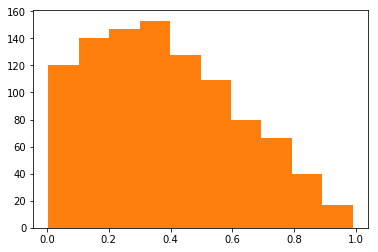

In [13]:
## simulate a generalized distribution
sim_n=1000
true_alpha,true_beta,true_loc,true_scale=1.4,2.2,0,1
sim_data = beta.rvs(true_alpha,true_beta,loc=true_loc,scale=true_scale,size=sim_n)
sim_bins2=plt.hist(sim_data)[1]
sim_probs2=plt.hist(sim_data)[0]/sim_n
sim_est=GeneralizedBetaEst(sim_bins2,sim_probs2)
sim_est

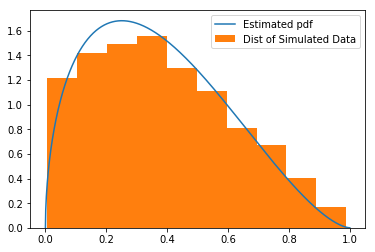

In [14]:
## plot the estimated generalized beta versus the histogram of simulated data drawn from a true beta distribution 
sim_x = np.linspace(true_loc,true_loc+true_scale,sim_n)
sim_pdf=beta.pdf(sim_x,sim_est[0],sim_est[1],loc=true_loc,scale=true_scale)
plt.plot(sim_x,sim_pdf,label='Estimated pdf')
plt.hist(sim_data,density=True,label='Dist of Simulated Data')
plt.legend(loc=0)

In [15]:
## This is the synthesized density estimation function
def SynDensityStat(bin,probs):
    """
    Synthesized density estimate module:
    It first detects the shape of histograms
    Then accordingly invoke the distribution-specific tool.
    
    paramters
    ---------
    bin:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
    
    returns
    -------
    moments: dict with 2 keys (more to be added in future)
            mean: empty or float, estimated mean 
            variance:  empty or float, estimated variance 
    
    """
    if sum(probs)==1:
        print("probs sum up to 1")
        ## Beta distributions 
        if sum([probs[i]>0 for i in range(len(bin)-1)])>=3:
            print("at least three bins with positive probs")
            para_est=GeneralizedBetaEst(bin,probs)
            if len(para_est)==4:
                print('4 parameters')
                return GeneralizedBetaStats(para_est[0],para_est[1],para_est[2],para_est[3])
            if len(para_est)==2:
                print('2 parameters')
                return GeneralizedBetaStats(para_est[0],para_est[1],0,1)
        ## Triangle distributions
        if sum([probs[i]>0 for i in range(len(bin)-1)])==2:
            #print("There are two bins with positive probs")
            pprobadj = [i for i in range(1,len(bin)-3) if probs[i]>0 and probs[i+1]>0]   # from 1 to -3 bcz excluding the open-ended on the left/right
            if sum(pprobadj)>0:
                #print('The two intervals are adjacent and not open-ended')
                para_est=TriangleEst(bin,probs)
                return TriangleStats(para_est['lb'],para_est['ub'])
        if sum([probs[i]>0 for i in range(len(bin)-1)])==1:
            print('Only one interval with positive probs')
            para_est= UniformEst(bin,probs)
            print(para_est)
            return UniformStats(para_est['lb'],para_est['ub'])
        else:
            return {"mean":[],"variance":[]}
    else:
        return {"mean":[],"variance":[]}

In [16]:
## testing the synthesized estimator function using an arbitrary example created above
SynDensityStat(sim_bins3,sim_probs3)['mean']

probs sum up to 1
Only one interval with positive probs
{'lb': 1.0, 'ub': 1.2}
yes


1.1

In [17]:
### loading probabilistic data  
IndSCE=pd.read_stata('../SurveyData/SCE/IncExpSCEProbIndM.dta')   
# monthly income growth 

In [20]:
IndSCE.head()

,date,year,month,userid,tenure,weight,Q24_cent25,Q24_cent50,Q24_cent75,Q24_var,...,Q24_varp5,Q24_varp95,Q24_sd,Q24_disg,Q24_meanp75,Q24_meanp25,Q24_meanp50,Q24_varp75,Q24_varp25,Q24_varp50
79059,2018-05-01,2018,5,70096793,1,0.583,2.621132,6.474436,10.566752,32.460587,...,0.276494,56.333328,2.325701,5.408885,3.916847,1.0,2.623311,4.723942,0.333333,0.940594
79060,2018-05-01,2018,5,70096796,1,0.495,2.334744,2.711993,3.089242,NaN,...,0.276494,56.333328,2.325701,5.408885,3.916847,1.0,2.623311,4.723942,0.333333,0.940594
79061,2018-05-01,2018,5,70096815,1,0.415,NaN,NaN,NaN,NaN,...,0.276494,56.333328,2.325701,5.408885,3.916847,1.0,2.623311,4.723942,0.333333,0.940594
79062,2018-05-01,2018,5,70096817,1,0.897,-3.213630,0.811724,5.496939,38.948586,...,0.276494,56.333328,2.325701,5.408885,3.916847,1.0,2.623311,4.723942,0.333333,0.940594
79063,2018-05-01,2018,5,70096821,1,0.583,2.334744,2.711993,3.089242,NaN,...,0.276494,56.333328,2.325701,5.408885,3.916847,1.0,2.623311,4.723942,0.333333,0.940594


In [22]:
## how many observations?
len(IndSCE)

79064

In [26]:
## how many observations have density forecasts
len(IndSCE['Q24_bin10'].dropna())

52820

In [27]:
## survey-specific parameters 
nobs=len(IndSCE)
SCE_bins=np.array([-20,-12,-8,-4,-2,0,2,4,8,12,20])
print("There are "+str(len(SCE_bins)-1)+" bins in SCE")

There are 10 bins in SCE


In [19]:
##############################################
### attention: the estimation happens here!!!!!
###################################################


## creating positions 
index  = IndSCE.index
columns=['IncMean','IncVar']
IndSCE_moment_est = pd.DataFrame(index=index,columns=columns)

## Invoking the estimation

for i in range(nobs):
    print(i)
    ## take the probabilities (flip to the right order, normalized to 0-1)
    Inc = np.flip(np.array([IndSCE.iloc[i,:]['Q24_bin'+str(n)]/100 for n in range(1,11)]))
    print(Inc)
    if not np.isnan(Inc).any():
        stats_est=SynDensityStat(SCE_bins,Inc)
        if len(stats_est)>0:
            IndSCE_moment_est['IncMean'][i]=stats_est['mean']
            print(stats_est['mean'])
            IndSCE_moment_est['IncVar'][i]=stats_est['variance']
            print(stats_est['variance'])

0
[nan nan nan nan nan nan nan nan nan nan]
1
[nan nan nan nan nan nan nan nan nan nan]
2
[0.   0.   0.   0.05 0.1  0.85 0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -4
upper bound is 2
2 parameters
0.8693898693418827
0.0476335800990423
3
[nan nan nan nan nan nan nan nan nan nan]
4
[nan nan nan nan nan nan nan nan nan nan]
5
[nan nan nan nan nan nan nan nan nan nan]
6
[nan nan nan nan nan nan nan nan nan nan]
7
[0.  0.  0.  0.  0.  0.  0.8 0.2 0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
3.8090169943749475
0.5454237476562285
8
[0.  0.  0.2 0.  0.  0.  0.  0.8 0.  0. ]
probs sum up to 1
[]
[]
9
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 0, 'ub': 2}
1.0
0.3333333333333333
10
[0.   0.   0.   0.   0.   0.95 0.05 0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and no

2 parameters
0.40769167597198414
0.02975160985735859
80
[0.   0.   0.   0.   0.   0.   0.05 0.5  0.2  0.25]
probs sum up to 1
at least three bins with positive probs
lower bound is 2
upper bound is 20
2 parameters
0.36479231337075996
0.04286383732774951
81
[0.   0.   0.   0.   0.   0.15 0.35 0.35 0.15 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 12
2 parameters
0.3814107653966683
0.047067469204494734
82
[0.  0.  0.  0.  0.  0.2 0.4 0.4 0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 8
2 parameters
0.4465586173143865
0.04352058624064613
83
[0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.6666666666666666
84
[0.  0.  0.  0.  0.  0.8 0.2 0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.8090169943749475
0.54542374

2 parameters
0.1660595749104077
0.00295544617837066
159
[0.  0.  0.  0.  0.  0.4 0.5 0.1 0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 8
2 parameters
0.3021921754119107
0.020538069854670653
160
[0.   0.   0.   0.   0.05 0.45 0.45 0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -2
upper bound is 8
2 parameters
0.4027812739869963
0.014713071830340433
161
[0.  0.  0.  0.  0.  0.1 0.8 0.1 0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 8
2 parameters
0.3725886847273669
0.009273767491809727
162
[0.   0.   0.   0.   0.1  0.2  0.2  0.25 0.2  0.05]
probs sum up to 1
at least three bins with positive probs
lower bound is -2
upper bound is 20
2 parameters
0.3099754928755021
0.035583048788601315
163
[nan nan nan nan nan nan nan nan nan nan]
164
[nan nan nan nan nan nan nan nan nan nan]
165
[nan nan nan nan nan nan nan nan nan nan]
166
[0.   0.   0.05 0.0

2 parameters
0.4999963755462454
0.04692366476605981
227
[0.   0.   0.   0.   0.25 0.25 0.5  0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -2
upper bound is 4
2 parameters
0.6061017235952004
0.10062068393217855
228
[0.   0.   0.   0.   0.25 0.5  0.25 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -2
upper bound is 4
2 parameters
0.4999963755462454
0.04692366476605981
229
[0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.6666666666666666
230
[0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.6666666666666666
231
[0.   0.   0.   0.   0.   0.   0.   0.   0.05 0.95]
probs sum up to 1
[]
[]
232
[0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.8]
probs sum up to 1
[]
[]
233
[0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. 

2 parameters
-2.3277463220045065
-0.032008968031355126
300
[nan nan nan nan nan nan nan nan nan nan]
301
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 4, 'ub': 8}
6.0
1.3333333333333333
302
[nan nan nan nan nan nan nan nan nan nan]
303
[nan nan nan nan nan nan nan nan nan nan]
304
[nan nan nan nan nan nan nan nan nan nan]
305
[nan nan nan nan nan nan nan nan nan nan]
306
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 2, 'ub': 4}
3.0
0.3333333333333333
307
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 2, 'ub': 4}
3.0
0.3333333333333333
308
[0.   0.   0.   0.   0.   0.   0.99 0.01 0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
3.111111111111111
0.2057613168724281
309
[0.  0.  0.  0.  0.  0.8 0.2 0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two in

2 parameters
0.8311334667957248
0.07639111415698822
391
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 2, 'ub': 4}
3.0
0.3333333333333333
392
[0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.6666666666666666
393
[0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is -2
upper bound is 4
2 parameters
0.49997967141229693
0.016198196210665577
394
[0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
probs sum up to 1
[]
[]
395
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
probs sum up to 1
Only one interval with positive probs
{'lb': 12, 'ub': 20}
16.0
5.333333333333333
396
[0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
8.0
2.6666666666666665
397
[0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
probs sum up to 1

2 parameters
0.4965469666603244
0.05057520933246478
464
[0.  0.  0.  0.  0.  0.1 0.2 0.5 0.2 0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 12
2 parameters
0.46468760922528174
0.047235515079733864
465
[0.   0.   0.   0.   0.   0.   0.25 0.5  0.25 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 2
upper bound is 12
2 parameters
0.4092615177556013
0.062008860790767895
466
[0.  0.  0.  0.  0.  0.3 0.2 0.4 0.1 0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 12
2 parameters
0.34836836061971044
0.055866693455083744
467
[0.  0.  0.  0.  0.  0.1 0.  0.4 0.5 0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 12
2 parameters
0.637809585089975
0.05888330315208975
468
[0.   0.   0.   0.   0.   0.35 0.65 0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.55137

2 parameters
0.41807519908523183
0.03283112306150529
554
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 0, 'ub': 2}
1.0
0.3333333333333333
555
[0.   0.   0.   0.   0.25 0.35 0.1  0.3  0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -2
upper bound is 8
2 parameters
0.4014662712464478
0.06987830728487765
556
[0.   0.   0.   0.   0.   0.15 0.25 0.25 0.35 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 12
2 parameters
0.4916365467469973
0.08900820269383677
557
[nan nan nan nan nan nan nan nan nan nan]
558
[nan nan nan nan nan nan nan nan nan nan]
559
[nan nan nan nan nan nan nan nan nan nan]
560
[nan nan nan nan nan nan nan nan nan nan]
561
[nan nan nan nan nan nan nan nan nan nan]
562
[0.   0.   0.   0.   0.   0.   0.06 0.5  0.4  0.04]
probs sum up to 1
at least three bins with positive probs
lower bound is 2
upper bound is 20
2 parameters
0.319680350581283
0

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 2, 'ub': 4}
3.0
0.3333333333333333
622
[0.   0.   0.   0.   0.   0.04 0.95 0.01 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 8
2 parameters
0.35367026496564163
0.003751075523735634
623
[0.  0.  0.  0.  0.  0.8 0.1 0.1 0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 8
2 parameters
0.13741118447368117
0.051661137020621875
624
[0.  0.  0.  0.  0.  0.8 0.1 0.1 0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 8
2 parameters
0.13741118447368117
0.051661137020621875
625
[0.  0.  0.  0.  0.  0.8 0.1 0.1 0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 8
2 parameters
0.13741118447368117
0.051661137020621875
626
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
probs sum up to 1
Only one interval with positive probs


2 parameters
0.49997967141229693
0.016198196210665577
677
[nan nan nan nan nan nan nan nan nan nan]
678
[nan nan nan nan nan nan nan nan nan nan]
679
[nan nan nan nan nan nan nan nan nan nan]
680
[nan nan nan nan nan nan nan nan nan nan]
681
[nan nan nan nan nan nan nan nan nan nan]
682
[nan nan nan nan nan nan nan nan nan nan]
683
[nan nan nan nan nan nan nan nan nan nan]
684
[nan nan nan nan nan nan nan nan nan nan]
685
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 0, 'ub': 2}
1.0
0.3333333333333333
686
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 0, 'ub': 2}
1.0
0.3333333333333333
687
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 0, 'ub': 2}
1.0
0.3333333333333333
688
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 2, 'ub': 4}
3.0
0.3333333333333333
689
[0.  0.  0.  0.  0.  0.1 0.9 0.  0.  0

2 parameters
0.4999963755462454
0.04692366476605981
759
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 0, 'ub': 2}
1.0
0.3333333333333333
760
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 0, 'ub': 2}
1.0
0.3333333333333333
761
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': -2, 'ub': 0}
-1.0
0.3333333333333333
762
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 0, 'ub': 2}
1.0
0.3333333333333333
763
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
0.0
0.6666666666666666
764
[nan nan nan nan nan nan nan nan nan nan]
765
[nan nan nan nan nan nan nan nan nan nan]
766
[nan nan nan nan nan nan nan nan nan nan]
767
[nan nan nan nan nan nan nan nan nan nan]
768
[nan nan nan nan nan nan nan nan nan nan]
769


2 parameters
0.1981235740963098
0.020337385160755925
826
[0.   0.   0.   0.   0.   0.2  0.4  0.15 0.15 0.1 ]
[]
[]
827
[0.   0.   0.   0.   0.   0.05 0.5  0.25 0.15 0.05]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 20
2 parameters
0.2388948153163453
0.018381926017596622
828
[0.   0.   0.   0.   0.   0.2  0.4  0.15 0.15 0.1 ]
[]
[]
829
[0.   0.   0.   0.   0.   0.15 0.3  0.3  0.15 0.1 ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 20
2 parameters
0.27852612698722246
0.0354226193185992
830
[0.   0.   0.   0.   0.   0.1  0.1  0.15 0.25 0.4 ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 20
2 parameters
0.5132909112895706
0.08308221984792484
831
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
0.0
0.6666666666666666
832
[0.   0.   0.   0.02 0.05 0.3  0.1  0.1

2 parameters
0.4180198951164061
0.005175456018056895
886
[nan nan nan nan nan nan nan nan nan nan]
887
[nan nan nan nan nan nan nan nan nan nan]
888
[0.  0.  0.  0.  0.  0.1 0.6 0.3 0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 8
2 parameters
0.4271069263558599
0.018795021405862554
889
[0.  0.  0.  0.  0.  0.3 0.1 0.6 0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 8
2 parameters
0.4549933551514387
-9.546850018827696e-05
890
[0.   0.   0.   0.   0.   0.   0.25 0.75 0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
4.0
2.6666666666666665
891
[0.   0.   0.   0.   0.   0.05 0.15 0.25 0.45 0.1 ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 20
2 parameters
0.40159581033051883
0.03449632645093729
892
[0.  0.  0.  0.  0.  0.  0.  0.1 0.9 0. ]
probs sum up to 1
There are two bins 

[nan nan nan nan nan nan nan nan nan nan]
958
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 2, 'ub': 4}
3.0
0.3333333333333333
959
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 0, 'ub': 2}
1.0
0.3333333333333333
960
[0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.6666666666666666
961
[0.  0.  0.  0.  0.  0.8 0.2 0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.8090169943749475
0.5454237476562283
962
[0.  0.  0.  0.  0.  0.  0.  0.8 0.1 0.1]
probs sum up to 1
at least three bins with positive probs
lower bound is 4
upper bound is 20
2 parameters
0.13741118447368117
0.051661137020621875
963
[nan nan nan nan nan nan nan nan nan nan]
964
[nan nan nan nan nan nan nan nan nan nan]
965
[nan nan nan nan nan nan nan nan n

[0.   0.   0.   0.   0.   0.19 0.4  0.35 0.05 0.01]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 20
2 parameters
0.19353122974783732
0.01105042468796743
1030
[0.   0.   0.   0.   0.   0.08 0.4  0.4  0.1  0.02]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 20
2 parameters
0.23064039046420035
0.013339558275893344
1031
[0.  0.  0.  0.  0.  0.9 0.1 0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.4624752955742644
0.35647233169417203
1032
[0.  0.  0.  0.  0.  0.8 0.2 0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.8090169943749475
0.5454237476562283
1033
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 0, 'ub': 2}
1.0
0.3333333333333333
1034
[0.  0.  0.  0.  0.  0.9 0.1 0.  0.  0. ]
probs sum up to 1
There are two

2 parameters
0.46604885466652757
0.04583547859463797
1087
[nan nan nan nan nan nan nan nan nan nan]
1088
[0.   0.05 0.05 0.1  0.1  0.2  0.2  0.2  0.05 0.05]
probs sum up to 1
at least three bins with positive probs
lower bound is -12
upper bound is 20
2 parameters
0.4392252570066358
0.018913649210768633
1089
[0.05 0.05 0.1  0.1  0.1  0.1  0.2  0.1  0.1  0.1 ]
[]
[]
1090
[0.   0.05 0.05 0.05 0.05 0.4  0.4  0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -12
upper bound is 4
2 parameters
0.8157859128782101
0.02165399875711494
1091
[0.05 0.05 0.05 0.05 0.05 0.3  0.15 0.1  0.1  0.1 ]
probs sum up to 1
at least three bins with positive probs
lower bound is -20
upper bound is 20
4 parameters
0.6666666666666666
0.05555555555555555
1092
[nan nan nan nan nan nan nan nan nan nan]
1093
[nan nan nan nan nan nan nan nan nan nan]
1094
[nan nan nan nan nan nan nan nan nan nan]
1095
[nan nan nan nan nan nan nan nan nan nan]
1096
[nan nan nan nan nan nan nan nan

2 parameters
0.5882272180519522
0.037564568520026376
1159
[0.  0.  0.  0.4 0.3 0.3 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is -4
upper bound is 2
2 parameters
0.45941445804890724
0.09202932742140202
1160
[0.   0.   0.   0.25 0.5  0.25 0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -4
upper bound is 2
2 parameters
0.4999963755462454
0.04692366476605981
1161
[0.   0.   0.   0.   0.   0.25 0.5  0.25 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 8
2 parameters
0.3808337953706179
0.029412616642319533
1162
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 2, 'ub': 4}
3.0
0.3333333333333333
1163
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 2, 'ub': 4}
3.0
0.3333333333333333
1164
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
probs sum up to 1
Only one interval with po

1275
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 4, 'ub': 8}
6.0
1.3333333333333333
1276
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 2, 'ub': 4}
3.0
0.3333333333333333
1277
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 2, 'ub': 4}
3.0
0.3333333333333333
1278
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 2, 'ub': 4}
3.0
0.3333333333333333
1279
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 2, 'ub': 4}
3.0
0.3333333333333333
1280
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 0, 'ub': 2}
1.0
0.3333333333333333
1281
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 2, 'ub': 4}
3.0
0.3333333333333333
1282
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
probs sum up to 1


2 parameters
0.314015084844115
0.06882643700910065
1346
[0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.6666666666666666
1347
[0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.6666666666666666
1348
[nan nan nan nan nan nan nan nan nan nan]
1349
[nan nan nan nan nan nan nan nan nan nan]
1350
[nan nan nan nan nan nan nan nan nan nan]
1351
[nan nan nan nan nan nan nan nan nan nan]
1352
[nan nan nan nan nan nan nan nan nan nan]
1353
[nan nan nan nan nan nan nan nan nan nan]
1354
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
0.0
0.6666666666666666
1355
[nan nan nan nan nan nan nan nan nan nan]
1356
[nan nan nan nan nan nan nan nan nan nan]
1357
[nan nan nan nan nan nan nan nan nan 

2 parameters
0.33099890287005146
0.01178357417364208
1431
[0.   0.   0.   0.   0.05 0.05 0.4  0.3  0.15 0.05]
probs sum up to 1
at least three bins with positive probs
lower bound is -2
upper bound is 20
2 parameters
0.31429004241723263
0.019418457961839573
1432
[nan nan nan nan nan nan nan nan nan nan]
1433
[nan nan nan nan nan nan nan nan nan nan]
1434
[nan nan nan nan nan nan nan nan nan nan]
1435
[nan nan nan nan nan nan nan nan nan nan]
1436
[nan nan nan nan nan nan nan nan nan nan]
1437
[nan nan nan nan nan nan nan nan nan nan]
1438
[nan nan nan nan nan nan nan nan nan nan]
1439
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 4, 'ub': 8}
6.0
1.3333333333333333
1440
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 4, 'ub': 8}
6.0
1.3333333333333333
1441
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 2, 'ub': 4}
3.0
0.3333333333333333
1442
[0.

2 parameters
0.4591742021978887
0.02550893412506537
1500
[0.  0.  0.  0.  0.  0.1 0.8 0.1 0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 8
2 parameters
0.3725886847273669
0.009273767491809727
1501
[0.   0.   0.   0.   0.   0.   0.65 0.35 0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
4.448627658938403
0.9992962353530268
1502
[nan nan nan nan nan nan nan nan nan nan]
1503
[0.   0.   0.   0.   0.   0.25 0.5  0.25 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 8
2 parameters
0.3808337953706179
0.029412616642319533
1504
[0.  0.  0.  0.  0.  0.2 0.6 0.2 0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 8
2 parameters
0.3769222299628934
0.020113004970172006
1505
[0.   0.   0.   0.   0.05 0.25 0.5  0.2  0.   0.  ]
probs sum up to 1
at least three bins with positive probs

2 parameters
0.2339643394375412
0.0864222497903194
1554
[0.  0.  0.  0.  0.  0.  0.  0.3 0.6 0.1]
[]
[]
1555
[0.   0.05 0.3  0.5  0.15 0.   0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -12
upper bound is 0
2 parameters
0.7055453873690934
0.015094211299634093
1556
[0.05 0.45 0.45 0.05 0.   0.   0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -20
upper bound is -2
2 parameters
0.6602524966929056
0.01778908851897979
1557
[0.   0.   0.   0.   0.05 0.95 0.   0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
0.7119928444737063
0.27649373878115563
1558
[0.   0.   0.   0.   0.05 0.9  0.05 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -2
upper bound is 4
2 parameters
0.5000316399676671
0.01019580620262044
1559
[0.  0.  0.  0.  0.  0.9 0.1 0.  0.  0. ]
probs sum up to 1
There are two bins

2 parameters
0.44668996406684136
0.127062691697112
1608
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
0.0
0.6666666666666666
1609
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 0, 'ub': 2}
1.0
0.3333333333333333
1610
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 2, 'ub': 4}
3.0
0.3333333333333333
1611
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 0, 'ub': 2}
1.0
0.3333333333333333
1612
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': -2, 'ub': 0}
-1.0
0.3333333333333333
1613
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 0, 'ub': 2}
1.0
0.3333333333333333
1614
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'

0.3333333333333333
1694
[nan nan nan nan nan nan nan nan nan nan]
1695
[0.1 0.1 0.3 0.1 0.2 0.2 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is -20
upper bound is 2
2 parameters
0.7070657198648221
0.04596073491658771
1696
[0.  0.  0.  0.  0.  0.2 0.8 0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.1909830056250525
0.5454237476562283
1697
[0.01 0.03 0.05 0.15 0.4  0.3  0.03 0.02 0.01 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -20
upper bound is 12
2 parameters
0.6017770486743629
0.0037376002052763846
1698
[0.   0.04 0.03 0.02 0.45 0.2  0.15 0.06 0.05 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -12
upper bound is 12
2 parameters
0.51077890992451
0.010089698615573617
1699
[0.   0.   0.   0.   0.45 0.35 0.2  0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -2
upper b

2 parameters
0.3539913965388594
0.02768249284382848
1753
[0.   0.   0.   0.   0.   0.3  0.65 0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 8
2 parameters
0.312713607114698
0.011384645794296093
1754
[0.  0.  0.  0.  0.  0.1 0.8 0.1 0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 8
2 parameters
0.3725886847273669
0.009273767491809727
1755
[0.  0.  0.  0.  0.2 0.6 0.2 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is -2
upper bound is 4
2 parameters
0.49999536111579357
0.03337473449588551
1756
[0.  0.  0.  0.  0.  0.4 0.5 0.1 0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 8
2 parameters
0.3021921754119107
0.020538069854670653
1757
[0.  0.  0.  0.  0.  0.5 0.4 0.1 0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 8
2 parameters
0.2734031606192609

2 parameters
0.6720924660838733
0.002491387610381758
1810
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
0.0
0.6666666666666666
1811
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
0.0
0.6666666666666666
1812
[nan nan nan nan nan nan nan nan nan nan]
1813
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 4, 'ub': 8}
6.0
1.3333333333333333
1814
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 4, 'ub': 8}
6.0
1.3333333333333333
1815
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 8, 'ub': 12}
10.0
1.3333333333333333
1816
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 2, 'ub': 4}
3.0
0.3333333333333333
1817

2 parameters
0.49997967141229693
0.016198196210665577
1888
[0.   0.   0.   0.   0.05 0.85 0.1  0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -2
upper bound is 4
2 parameters
0.5203516554241453
0.012687953321058229
1889
[0.  0.  0.  0.  0.3 0.7 0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
-0.21103222500738017
0.8147772500035144
1890
[0.   0.   0.02 0.15 0.75 0.05 0.03 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -8
upper bound is 4
2 parameters
0.567967216695589
0.004989848946287415
1891
[0.01 0.01 0.03 0.2  0.75 0.   0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -20
upper bound is 0
2 parameters
0.9294476297211126
0.004291597520854993
1892
[0.  0.  0.  0.  0.  0.1 0.9 0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not 

2.0
0.6666666666666666
1943
[0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.6666666666666666
1944
[0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.6666666666666666
1945
[0.  0.  0.  0.  0.  0.2 0.6 0.2 0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 8
2 parameters
0.3769222299628934
0.020113004970172006
1946
[0.25 0.12 0.1  0.02 0.02 0.02 0.05 0.1  0.12 0.2 ]
probs sum up to 1
at least three bins with positive probs
lower bound is -20
upper bound is 20
4 parameters
0.6666666666666666
0.05555555555555555
1947
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[]
[]
1948
[0.1  0.1  0.1  0.1  0.1  0.05 0.05 0.1  0.1  0.2 ]
probs sum up to 1
at least three bins with positive probs
lower bound is -20
upper bound is 20
4 parameters
0.6666666

2 parameters
0.3872192077382638
0.04386636998143215
2033
[0.   0.   0.   0.   0.   0.8  0.15 0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 8
2 parameters
0.1384268172353527
0.027461039661003564
2034
[0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is -2
upper bound is 4
2 parameters
0.49997967141229693
0.016198196210665577
2035
[0.   0.   0.   0.   0.   0.15 0.85 0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.367884312210892
0.4439669363878853
2036
[0.  0.  0.  0.  0.  0.4 0.6 0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.2792407799438734
1.233755122253404
2037
[nan nan nan nan nan nan nan nan nan nan]
2038
[nan nan nan nan nan nan nan nan nan nan]
2039
[nan nan nan nan nan nan nan nan nan nan]
2040
[nan nan nan n

2 parameters
0.3808337953706179
0.029412616642319533
2140
[0.  0.  0.  0.  0.3 0.3 0.3 0.1 0.  0. ]
[]
[]
2141
[nan nan nan nan nan nan nan nan nan nan]
2142
[nan nan nan nan nan nan nan nan nan nan]
2143
[nan nan nan nan nan nan nan nan nan nan]
2144
[nan nan nan nan nan nan nan nan nan nan]
2145
[nan nan nan nan nan nan nan nan nan nan]
2146
[nan nan nan nan nan nan nan nan nan nan]
2147
[nan nan nan nan nan nan nan nan nan nan]
2148
[nan nan nan nan nan nan nan nan nan nan]
2149
[nan nan nan nan nan nan nan nan nan nan]
2150
[nan nan nan nan nan nan nan nan nan nan]
2151
[nan nan nan nan nan nan nan nan nan nan]
2152
[nan nan nan nan nan nan nan nan nan nan]
2153
[nan nan nan nan nan nan nan nan nan nan]
2154
[nan nan nan nan nan nan nan nan nan nan]
2155
[nan nan nan nan nan nan nan nan nan nan]
2156
[nan nan nan nan nan nan nan nan nan nan]
2157
[0.  0.  0.  0.  0.2 0.5 0.3 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is -2
upper bound is 4
2 

2 parameters
0.11218423441535436
-2.950843367696589e-05
2216
[0.   0.   0.   0.   0.   0.   0.8  0.1  0.05 0.05]
probs sum up to 1
at least three bins with positive probs
lower bound is 2
upper bound is 20
2 parameters
0.06875755797015264
-1.6993898328333573e-05
2217
[0.  0.  0.  0.  0.  0.  0.5 0.4 0.1 0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 2
upper bound is 12
2 parameters
0.2594698439875682
0.04985904526765652
2218
[0.   0.   0.   0.   0.   0.1  0.6  0.15 0.1  0.05]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 20
2 parameters
0.17288486494078895
0.00371111893026579
2219
[0.  0.  0.  0.  0.  0.3 0.5 0.2 0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 8
2 parameters
0.3539913965388594
0.02768249284382848
2220
[0.  0.  0.  0.  0.  0.  0.8 0.1 0.1 0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 2
upper bound is 12
2 parameter

4 parameters
0.6666666666666666
0.05555555555555555
2280
[0.01 0.02 0.05 0.05 0.1  0.3  0.3  0.1  0.05 0.02]
probs sum up to 1
at least three bins with positive probs
lower bound is -20
upper bound is 20
4 parameters
0.6666666666666666
0.05555555555555555
2281
[0.05 0.05 0.05 0.05 0.2  0.25 0.2  0.05 0.05 0.05]
[]
[]
2282
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 0, 'ub': 2}
1.0
0.3333333333333333
2283
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 0, 'ub': 2}
1.0
0.3333333333333333
2284
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 0, 'ub': 2}
1.0
0.3333333333333333
2285
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
0.0
0.6666666666666666
2286
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive p

[0.  0.  0.  0.  0.  0.8 0.2 0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.8090169943749475
0.5454237476562283
2343
[0.   0.   0.   0.   0.   0.01 0.99 0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.888888888888889
0.20576131687242782
2344
[0.   0.   0.   0.   0.   0.1  0.85 0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 8
2 parameters
0.3564339102255158
0.0070349232417798975
2345
[0.   0.   0.   0.   0.   0.1  0.85 0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 8
2 parameters
0.3564339102255158
0.0070349232417798975
2346
[0.   0.   0.   0.   0.   0.1  0.85 0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 8
2 parameters
0.3564339102255158
0.0070349232417798975
23

2 parameters
0.08089046414261243
-2.403168538340502e-05
2398
[0.  0.  0.  0.  0.  0.1 0.8 0.1 0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 8
2 parameters
0.3725886847273669
0.009273767491809727
2399
[0.  0.  0.  0.  0.  0.1 0.8 0.1 0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 8
2 parameters
0.3725886847273669
0.009273767491809727
2400
[0.   0.   0.   0.   0.   0.25 0.6  0.15 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 8
2 parameters
0.35171614514126365
0.018803348112566627
2401
[0.  0.  0.  0.  0.  0.1 0.7 0.2 0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0
upper bound is 8
2 parameters
0.3995725887314861
0.013659550523778891
2402
[0.  0.  0.  0.  0.  0.3 0.7 0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.788967774

2 parameters
0.6413173137877248
0.04589167285009939
2451
[0.   0.1  0.1  0.1  0.1  0.25 0.25 0.1  0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -12
upper bound is 8
2 parameters
0.6028095693436246
0.03629668995623921
2452
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': -2, 'ub': 0}
-1.0
0.3333333333333333
2453
[0.  0.  0.1 0.6 0.3 0.  0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is -8
upper bound is 0
2 parameters
0.6732880953612997
0.016319672055809396
2454
[0.  0.  0.  0.  0.8 0.2 0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
-0.19098300562505266
0.5454237476562281
2455
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': 4, 'ub': 8}
6.0
1.3333333333333333
2456
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
probs sum up to 1
Only one interval with positive

AttributeError: 'list' object has no attribute 'size'

In [20]:
### exporting moments estimates to pkl
IndSCE_est = pd.concat([IndSCE,IndSCE_moment_est], join='inner', axis=1)
IndSCE_est.to_pickle("./IndSCEDstIndM.pkl")
IndSCE_pk = pd.read_pickle('./IndSCEDstIndM.pkl')

In [21]:
IndSCE_pk['IncMean']=pd.to_numeric(IndSCE_pk['IncMean'],errors='coerce')   # income growth from y-1 to y 
IndSCE_pk['IncVar']=pd.to_numeric(IndSCE_pk['IncVar'],errors='coerce')   

In [22]:
IndSCE_pk.tail()

,date,year,month,userid,tenure,weight,Q24_cent25,Q24_cent50,Q24_cent75,Q24_var,...,Q24_sd,Q24_disg,Q24_meanp75,Q24_meanp25,Q24_meanp50,Q24_varp75,Q24_varp25,Q24_varp50,IncMean,IncVar
79059,2018-05-01,2018,5,70096793,1,0.583,2.621132,6.474436,10.566752,32.460587,...,2.325701,5.408885,3.916847,1.0,2.623311,4.723942,0.333333,0.940594,NaN,NaN
79060,2018-05-01,2018,5,70096796,1,0.495,2.334744,2.711993,3.089242,NaN,...,2.325701,5.408885,3.916847,1.0,2.623311,4.723942,0.333333,0.940594,NaN,NaN
79061,2018-05-01,2018,5,70096815,1,0.415,NaN,NaN,NaN,NaN,...,2.325701,5.408885,3.916847,1.0,2.623311,4.723942,0.333333,0.940594,NaN,NaN
79062,2018-05-01,2018,5,70096817,1,0.897,-3.213630,0.811724,5.496939,38.948586,...,2.325701,5.408885,3.916847,1.0,2.623311,4.723942,0.333333,0.940594,NaN,NaN
79063,2018-05-01,2018,5,70096821,1,0.583,2.334744,2.711993,3.089242,NaN,...,2.325701,5.408885,3.916847,1.0,2.623311,4.723942,0.333333,0.940594,NaN,NaN


In [23]:
columns_keep = ['date','year','month','userid','tenure','IncMean','IncVar']
IndSCE_pk_new = IndSCE_pk[columns_keep]
IndSCE_pk_new.to_stata('../SurveyData/SCE/IncExpSCEDstIndM.dta')

6 abnormals
908
-10.0
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': -12, 'ub': -8}
-10.0
1552
-9.075049408851472
[0.  0.9 0.1 0.  0.  0.  0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
-9.075049408851472
1703
-10.0
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': -12, 'ub': -8}
-10.0
1833
-10.0
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': -12, 'ub': -8}
-10.0
2066
-10.0
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
{'lb': -12, 'ub': -8}
-10.0


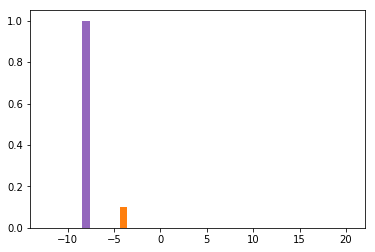

In [24]:
### Robustness checks: focus on big negative mean estimates 
sim_bins_data = SCE_bins
print(str(sum(IndSCE_pk['IncMean']<-6))+' abnormals')
ct=0
figure=plt.plot()
for id in IndSCE_pk.index[IndSCE_pk['IncMean']<-8]:
    print(id)
    print(IndSCE_pk['IncMean'][id])
    sim_probs_data= np.flip(np.array([IndSCE['Q24_bin'+str(n)][id]/100 for n in range(1,11)]))
    plt.bar(sim_bins_data[1:],sim_probs_data)
    print(sim_probs_data)
    stats_est=SynDensityStat(SCE_bins,sim_probs_data)
    print(stats_est['mean'])